# A. Geographic

### 1. Packages

In [2]:
import pandas as pd
import os
import numpy as np
from pyproj import Transformer
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import geopandas as gpd
import h3
from shapely.geometry import Polygon
import pyproj
from matplotlib.collections import PolyCollection
from shapely.geometry import Point, Polygon
from matplotlib.ticker import FuncFormatter
import folium


### 2. Data

In [4]:
print(os.getcwd())
os.chdir('/Users/clemenspaulsen/Desktop/Bootcamp/Project/Data')
print(os.getcwd())

/Users/clemenspaulsen
/Users/clemenspaulsen/Desktop/Bootcamp/Project/Data


In [6]:
df = pd.read_csv('df_clean_before_NaNs_with_datetime_infos.csv', index_col='IncidentNumber', 
                 dtype = {'IncidentNumber': 'str'}, parse_dates=['DateTimeCall'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537704 entries, 235138081 to 067903-30042024
Data columns (total 26 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   DateTimeCall                           1537704 non-null  datetime64[ns]
 1   DeployedFromStation_Name               1537697 non-null  object        
 2   DeployedFromLocation                   1537157 non-null  float64       
 3   PlusCode_Description                   1537704 non-null  object        
 4   IncidentGroup                          1537704 non-null  object        
 5   StopCodeDescription                    1537704 non-null  object        
 6   PropertyCategory                       1537704 non-null  object        
 7   Postcode_district                      1537704 non-null  object        
 8   IncGeo_BoroughName                     1537704 non-null  object        
 9   IncGeo_WardNameNew      

### 3. LonLat

In [8]:
# Define the BNG and WGS84 coordinate systems using Transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)

# Extract the easting and northing columns as NumPy arrays
eastings = df['Easting_rounded'].to_numpy()
northings = df['Northing_rounded'].to_numpy()

# Define the chunk size
chunk_size = 100000

# Initialize lists to store results
Longitude_list = []
Latitude_list = []

# Process data in chunks with progress tracking
for i in tqdm(range(0, len(eastings), chunk_size), desc="Converting coordinates"):
    easting_chunk = eastings[i:i + chunk_size]
    northing_chunk = northings[i:i + chunk_size]
    
    Longitudes, Latitudes = transformer.transform(easting_chunk, northing_chunk)
    
    Longitude_list.append(Longitudes)
    Latitude_list.append(Latitudes)

# Concatenate the results
df['Longitude'] = np.concatenate(Longitude_list)
df['Latitude'] = np.concatenate(Latitude_list)

# Print the DataFrame to check the new columns
print(df[['Easting_rounded', 'Northing_rounded', 'Longitude', 'Latitude']])

Converting coordinates: 100%|███████████████████| 16/16 [00:00<00:00, 25.84it/s]

                 Easting_rounded  Northing_rounded  Longitude   Latitude
IncidentNumber                                                          
235138081                 528650            176850  -0.148941  51.475991
2091                      533750            194450  -0.068862  51.632968
3091                      507750            182850  -0.447922  51.534283
5091                      531050            185350  -0.111246  51.551827
6091                      529450            185250  -0.134346  51.551297
...                          ...               ...        ...        ...
067897-30042024           524950            180150  -0.201022  51.506477
067898-30042024           539950            181350   0.015449  51.513748
067896-30042024           530850            190850  -0.112082  51.601298
067902-30042024           537450            170850  -0.024635  51.420006
067903-30042024           539650            187450   0.013547  51.568636

[1537704 rows x 4 columns]


In [10]:
print('Longitude: ', df['Longitude'].describe())
print('Latitude: ', df['Latitude'].describe())

missing_Longitude = df['Longitude'].isnull().sum()
print(f"Missing values in 'Longitude': {missing_Longitude}")

missing_Latitude = df['Latitude'].isnull().sum()
print(f"Missing values in 'Latitude': {missing_Latitude}")

Longitude:  count    1.537704e+06
mean    -1.193119e-01
std      1.411817e-01
min     -5.106512e-01
25%     -1.978013e-01
50%     -1.157929e-01
75%     -3.607857e-02
max      3.225420e-01
Name: Longitude, dtype: float64
Latitude:  count    1.537704e+06
mean     5.150805e+01
std      6.638228e-02
min      5.128766e+01
25%      5.146922e+01
50%      5.151351e+01
75%      5.155051e+01
max      5.169206e+01
Name: Latitude, dtype: float64
Missing values in 'Longitude': 0
Missing values in 'Latitude': 0


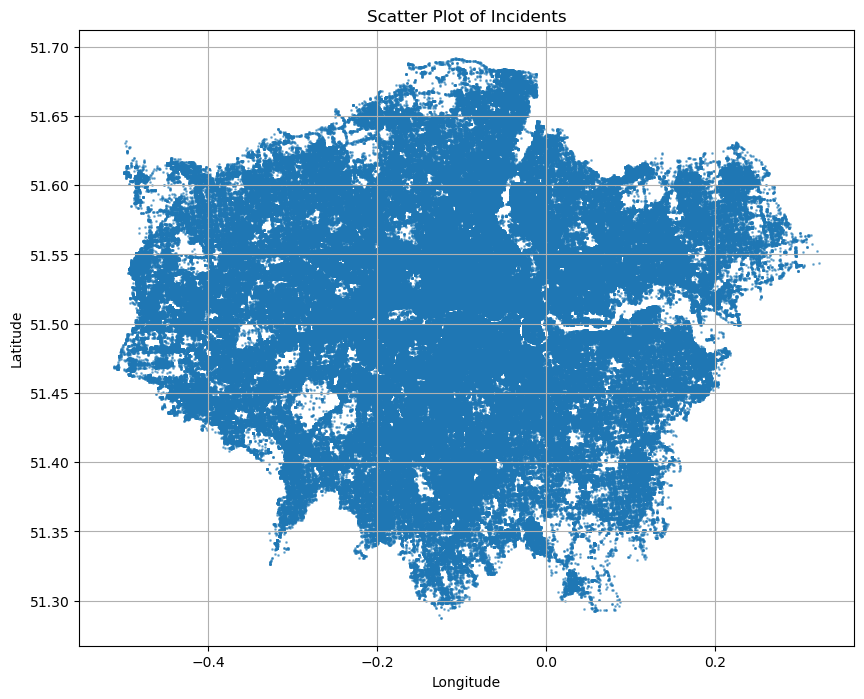

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(df['Longitude'], df['Latitude'], s=1, alpha=0.5)
plt.title('Scatter Plot of Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.savefig('/Users/clemenspaulsen/Desktop/Bootcamp/Project/Graphs/LFB_Incidents_Scatter.png', dpi=300)
plt.show()

### 4. Grid

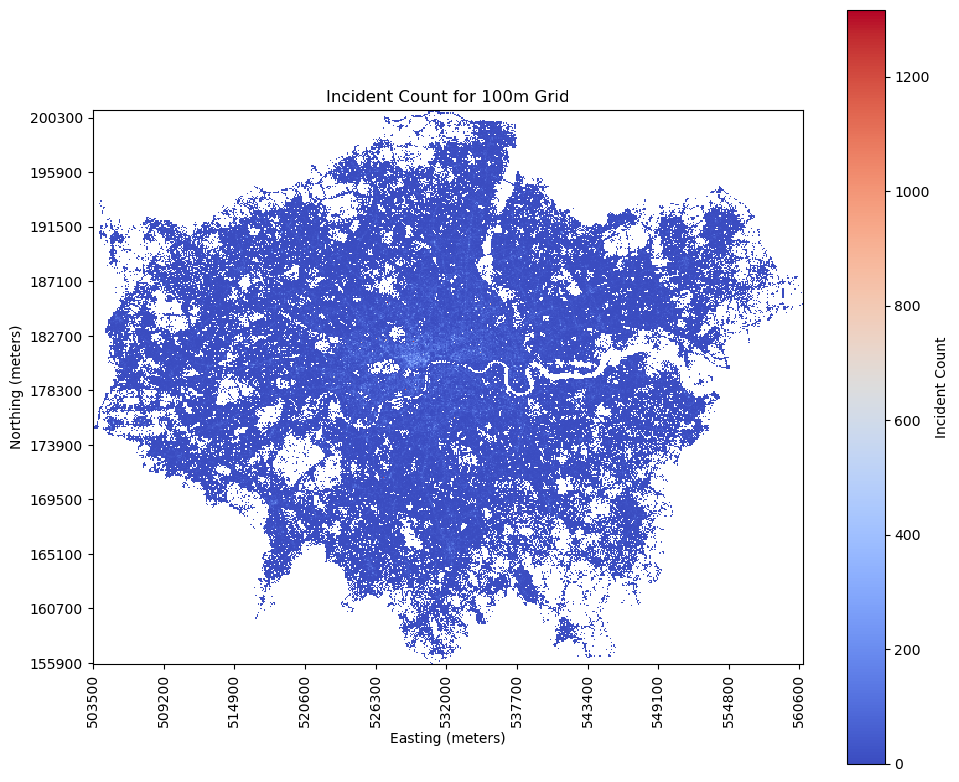

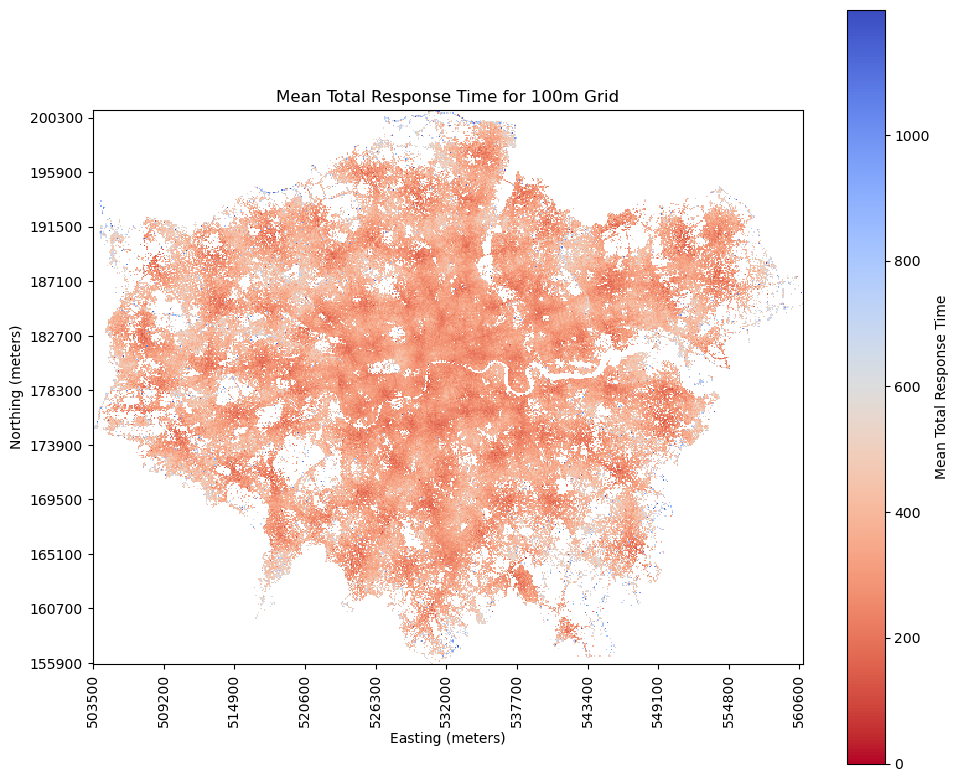

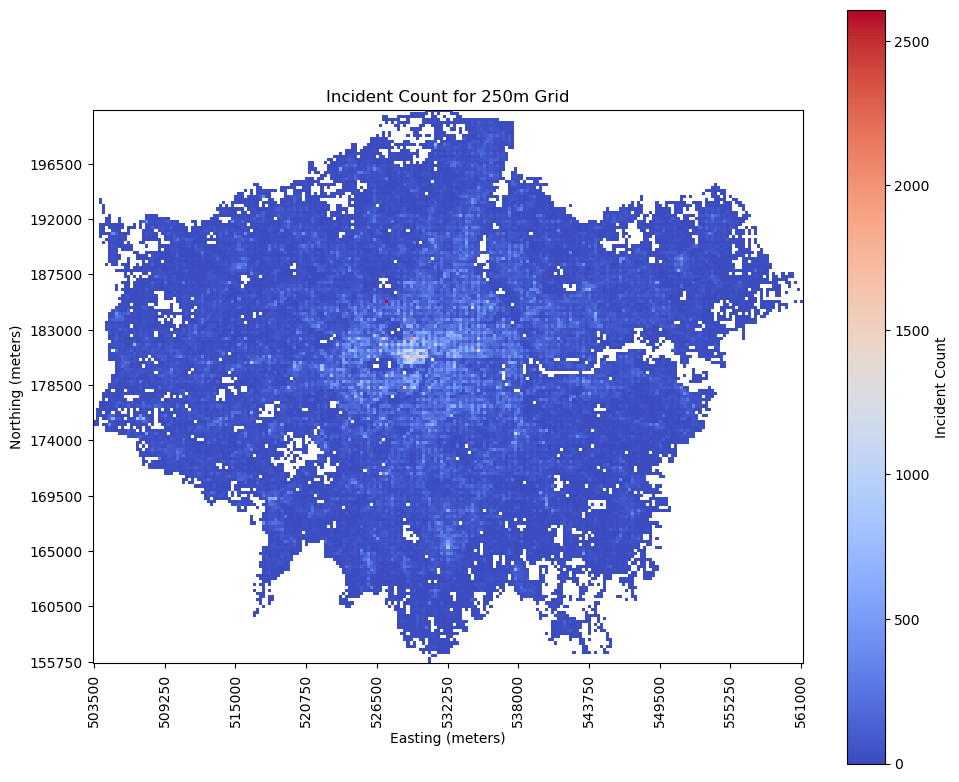

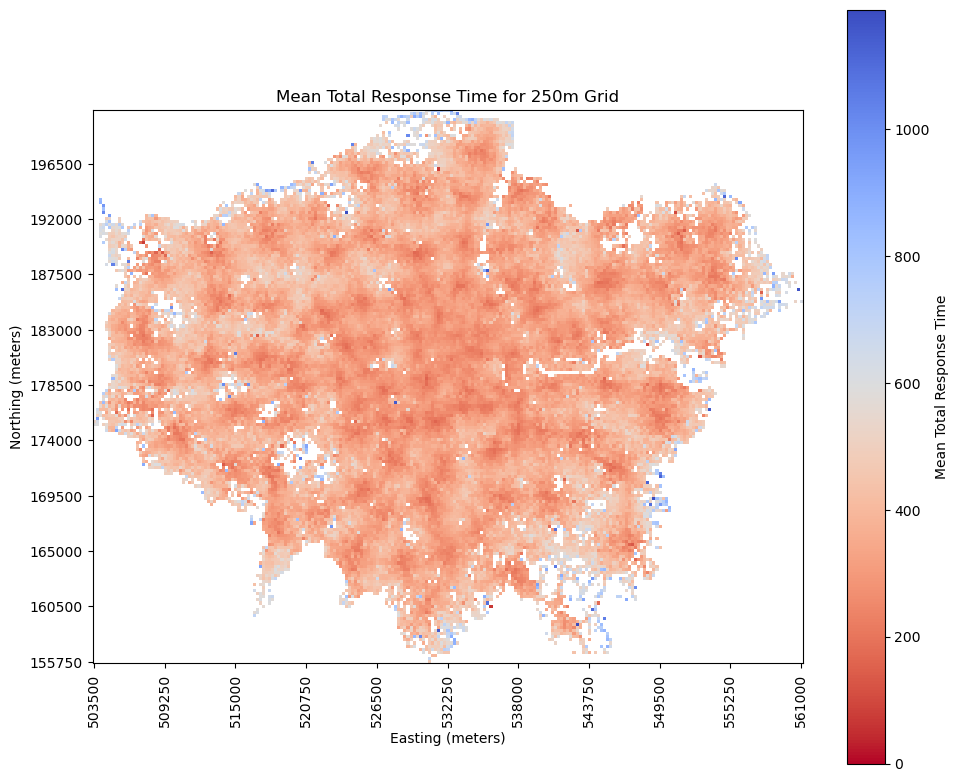

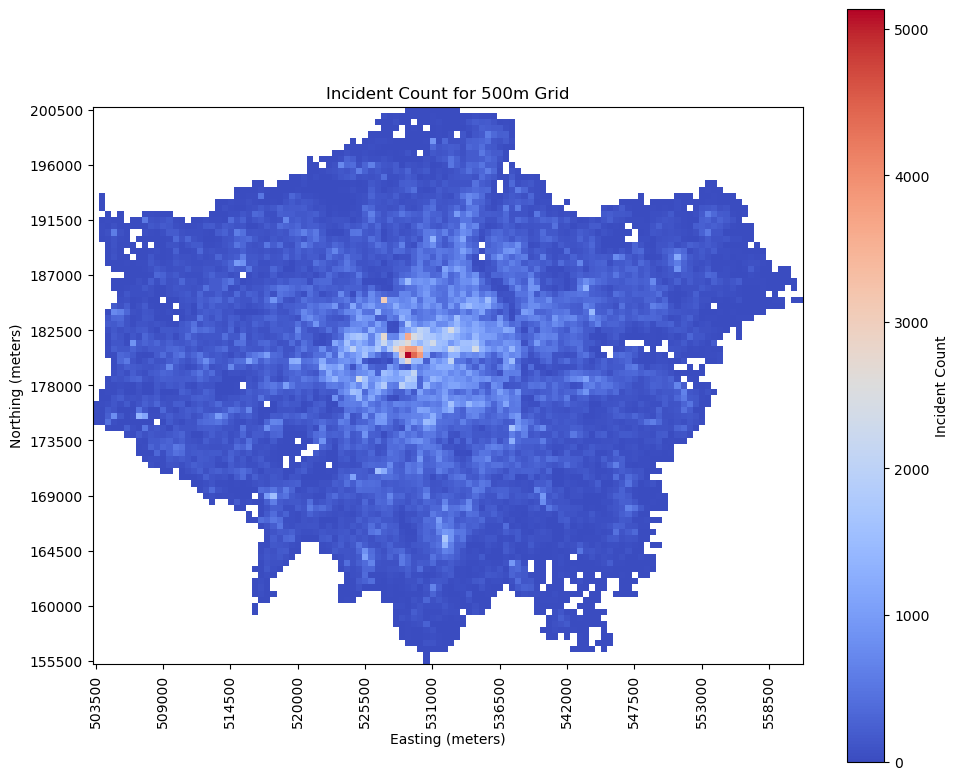

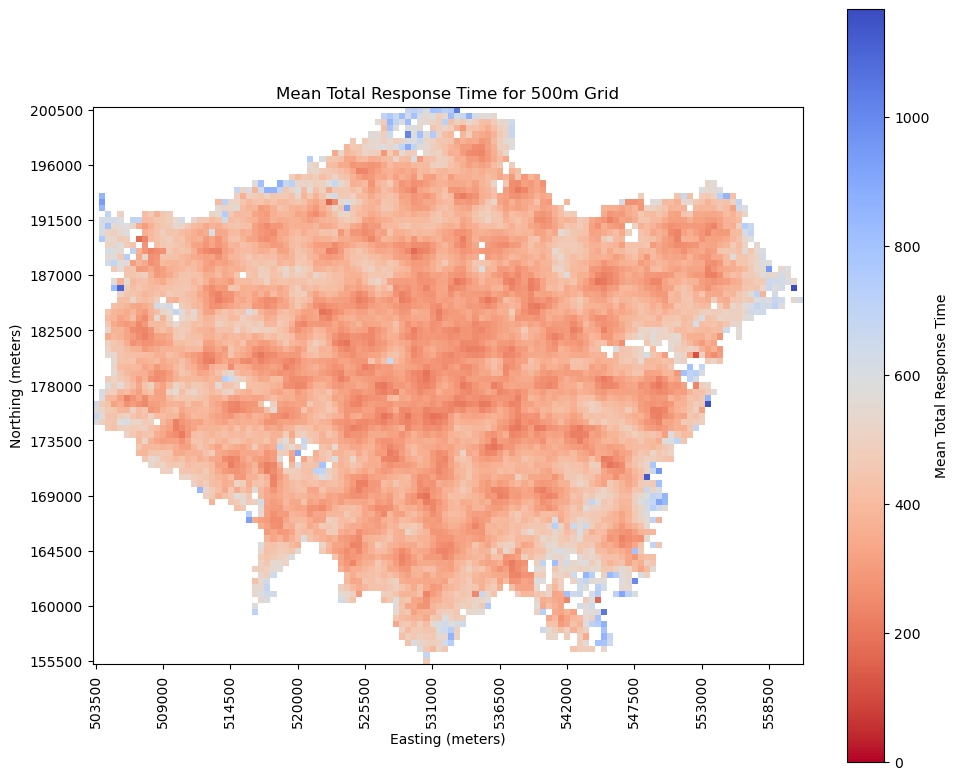

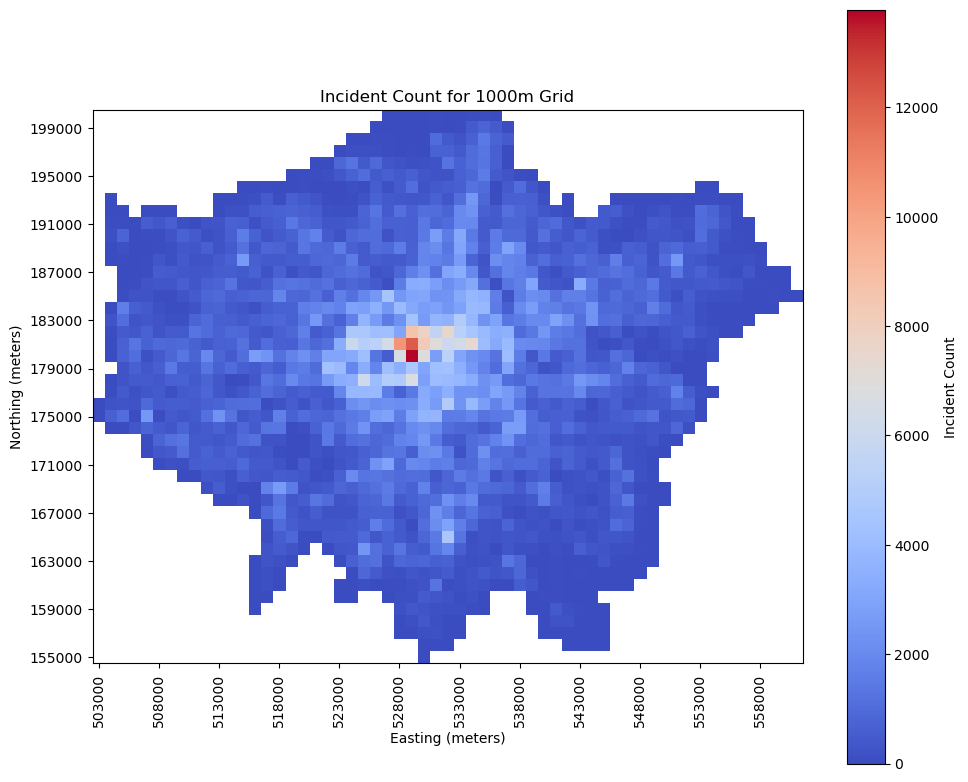

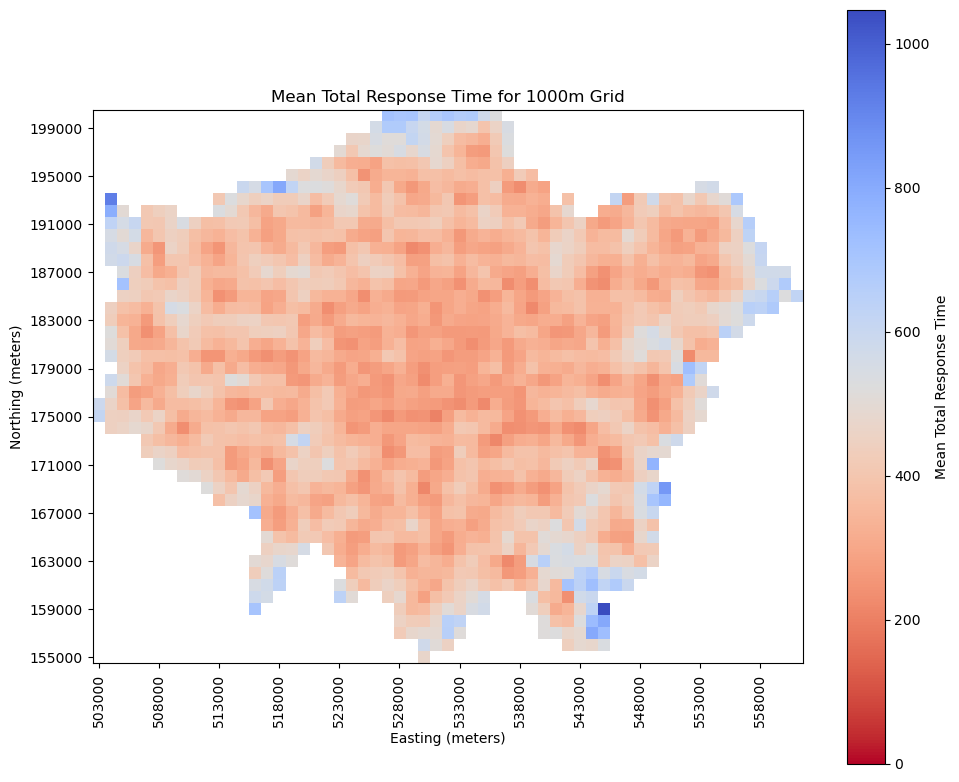

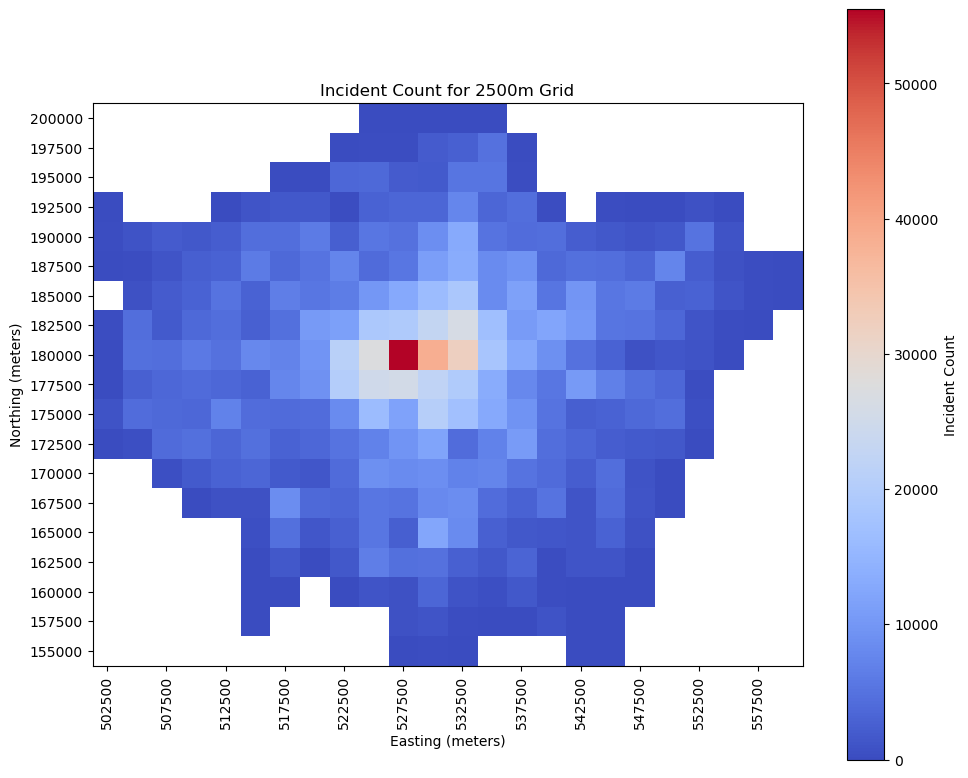

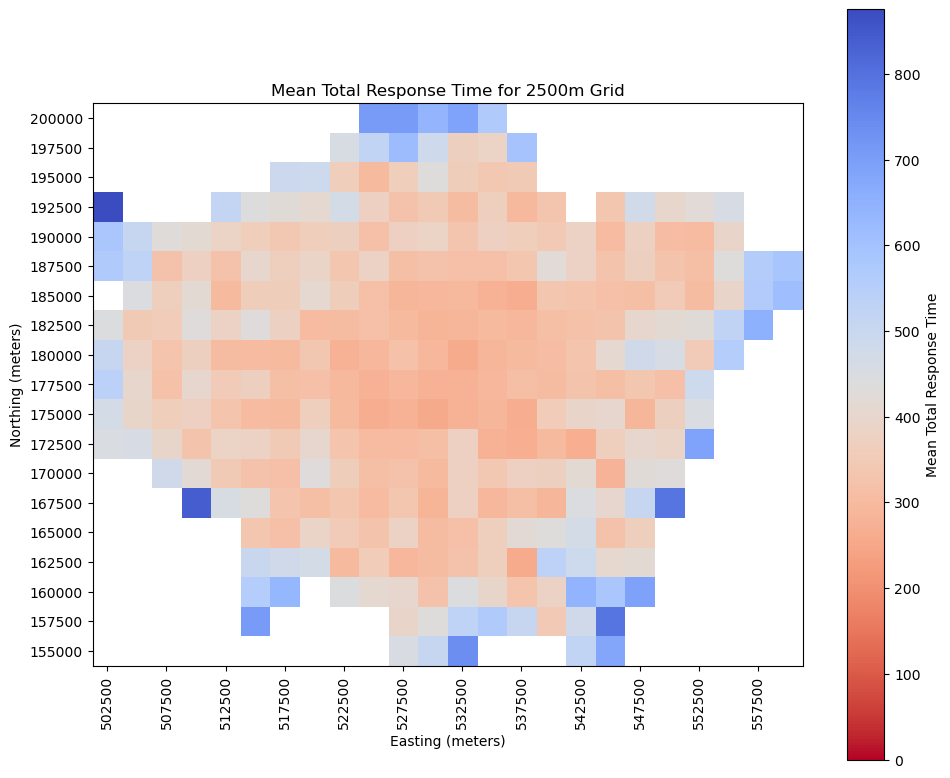

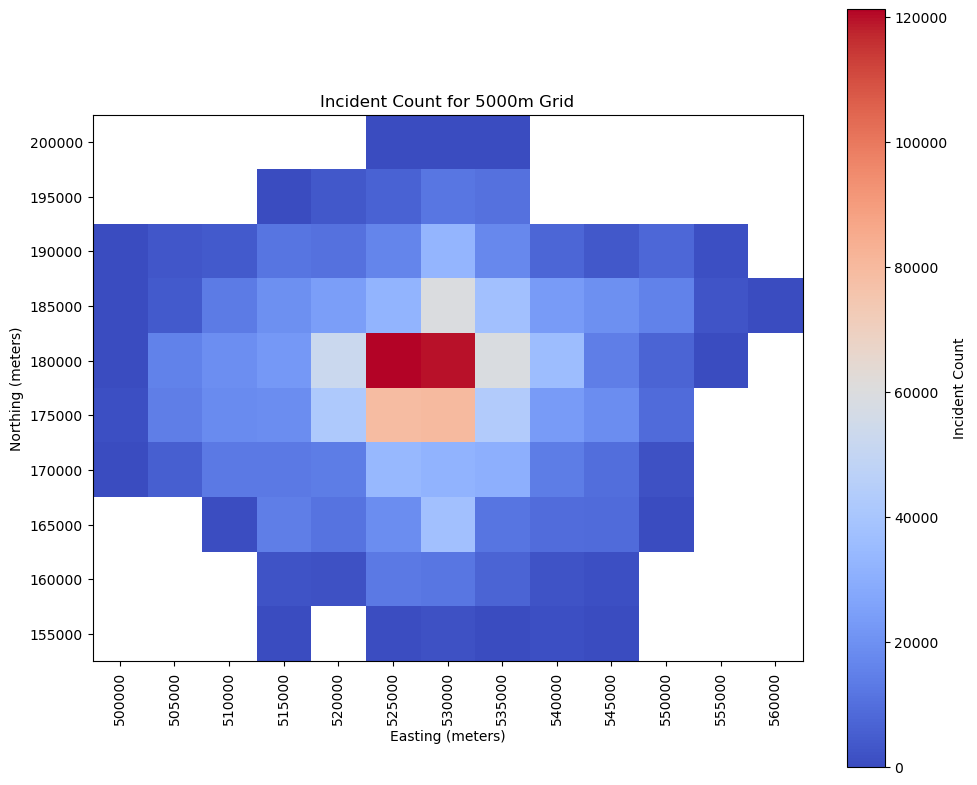

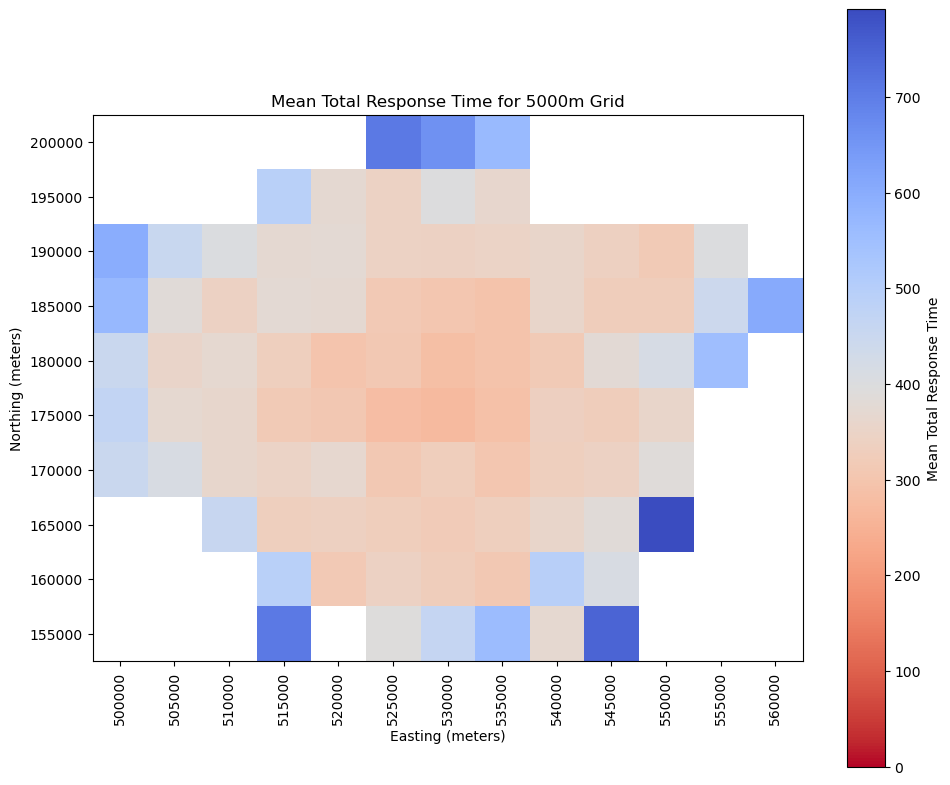

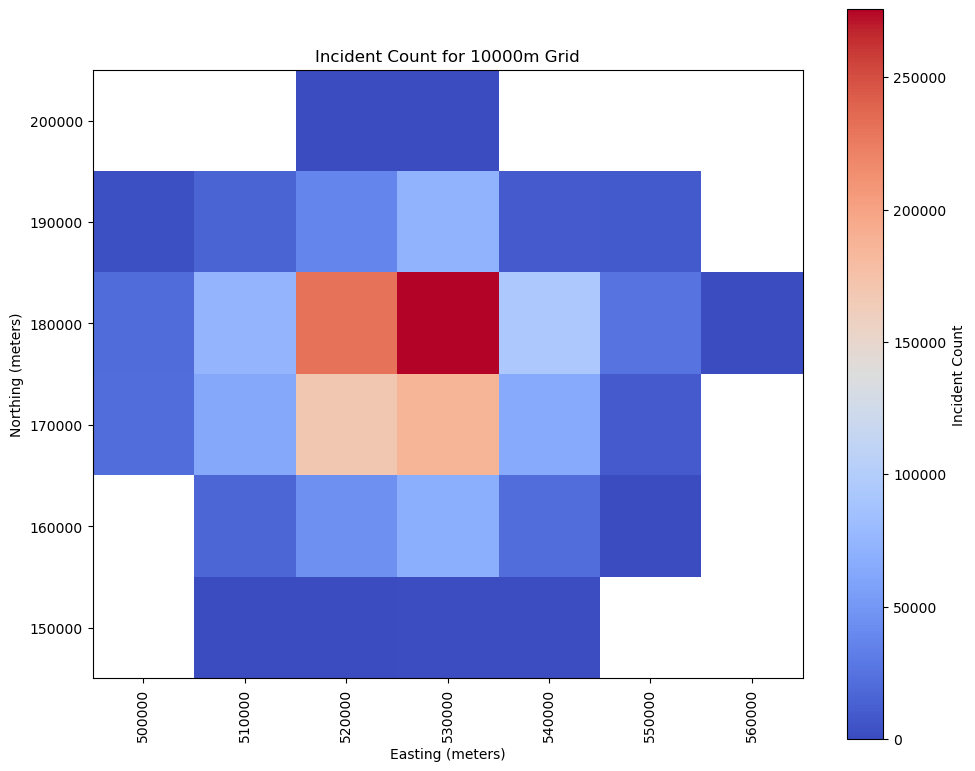

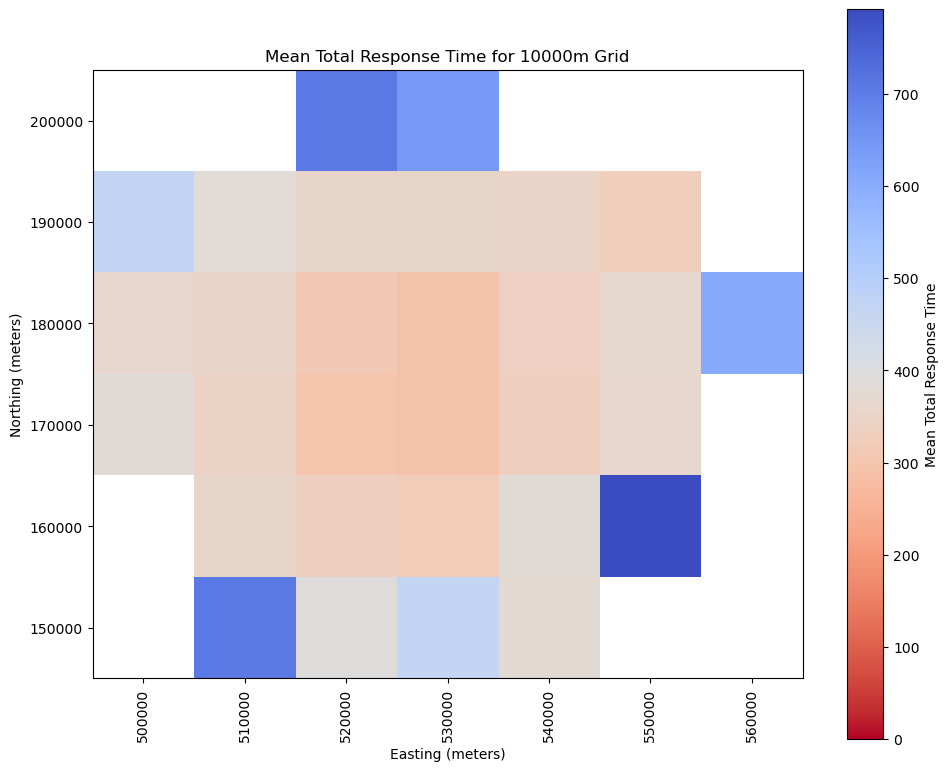

In [14]:
# List of grid sizes
grid_sizes = [100, 250, 500, 1000, 2500, 5000, 10000]

# Create separate DataFrames for each grid size and visualize
for grid_size in grid_sizes:
    # Create the grid cell columns based on the current grid size
    df[f'Easting_cell_{grid_size}'] = df['Easting_rounded'] // grid_size * grid_size
    df[f'Northing_cell_{grid_size}'] = df['Northing_rounded'] // grid_size * grid_size

    # Group by the grid cells and perform the aggregation
    df_grid = df.groupby([f'Easting_cell_{grid_size}', f'Northing_cell_{grid_size}']).agg(
        observation_count=('Easting_rounded', 'size'),
        mean_total_response_time=('TotalResponseTime', 'mean')
    ).reset_index()

    # Pivot the table to create a 2D grid for visualization
    pivot_table_count = df_grid.pivot_table(index=f'Northing_cell_{grid_size}', columns=f'Easting_cell_{grid_size}', values='observation_count')
    pivot_table_response_time = df_grid.pivot_table(index=f'Northing_cell_{grid_size}', columns=f'Easting_cell_{grid_size}', values='mean_total_response_time')

    # Plot the incident count heatmap
    fig_count, ax_count = plt.subplots(figsize=(10, 8))
    im_count = ax_count.imshow(pivot_table_count, cmap='coolwarm', interpolation='nearest', origin='lower')
    ax_count.set_title(f'Incident Count for {grid_size}m Grid')
    ax_count.set_xlabel('Easting (meters)')
    ax_count.set_ylabel('Northing (meters)')
    plt.colorbar(im_count, ax=ax_count, label='Incident Count')
    
    # Masking NaN values for incident count heatmap
    mask_count = np.isnan(pivot_table_count)
    masked_count = np.ma.array(pivot_table_count, mask=mask_count)
    im_count.set_data(masked_count)
    im_count.set_clim(0, np.nanmax(pivot_table_count))

    # Set x and y ticks to display fewer labels
    x_ticks = np.arange(0, len(pivot_table_count.columns), max(1, len(pivot_table_count.columns)//10))
    y_ticks = np.arange(0, len(pivot_table_count.index), max(1, len(pivot_table_count.index)//10))
    
    ax_count.set_xticks(x_ticks)
    ax_count.set_xticklabels(pivot_table_count.columns[x_ticks], rotation=90)
    ax_count.set_yticks(y_ticks)
    ax_count.set_yticklabels(pivot_table_count.index[y_ticks])

    # Save the incident count plot
    count_filename = f'/Users/clemenspaulsen/Desktop/Bootcamp/Project/Graphs/LFB_Incident_Grid{grid_size}_Count.png'
    plt.tight_layout()
    plt.savefig(count_filename, dpi=300)
    plt.show()
    
    # Plot the mean total response time heatmap
    fig_response, ax_response = plt.subplots(figsize=(10, 8))
    im_response = ax_response.imshow(pivot_table_response_time, cmap='coolwarm_r', interpolation='nearest', origin='lower')
    ax_response.set_title(f'Mean Total Response Time for {grid_size}m Grid')
    ax_response.set_xlabel('Easting (meters)')
    ax_response.set_ylabel('Northing (meters)')
    plt.colorbar(im_response, ax=ax_response, label='Mean Total Response Time')
    
    # Masking NaN values for mean total response time heatmap
    mask_response_time = np.isnan(pivot_table_response_time)
    masked_response_time = np.ma.array(pivot_table_response_time, mask=mask_response_time)
    im_response.set_data(masked_response_time)
    im_response.set_clim(0, np.nanmax(pivot_table_response_time))

    # Set x and y ticks to display fewer labels
    ax_response.set_xticks(x_ticks)
    ax_response.set_xticklabels(pivot_table_response_time.columns[x_ticks], rotation=90)
    ax_response.set_yticks(y_ticks)
    ax_response.set_yticklabels(pivot_table_response_time.index[y_ticks])

    # Save the mean total response time plot
    response_filename = f'/Users/clemenspaulsen/Desktop/Bootcamp/Project/Graphs/LFB_Incident_Grid{grid_size}_Response.png'
    plt.tight_layout()
    plt.savefig(response_filename, dpi=300)
    plt.show()


In [16]:
df['CellEastingNorthing100'] = df['Easting_cell_100'].astype(str) + '-' + df['Northing_cell_100'].astype(str)
df = df.drop(columns=['Easting_cell_100', 'Northing_cell_100'])

df['CellEastingNorthing250'] = df['Easting_cell_250'].astype(str) + '-' + df['Northing_cell_250'].astype(str)
df = df.drop(columns=['Easting_cell_250', 'Northing_cell_250'])

df['CellEastingNorthing500'] = df['Easting_cell_500'].astype(str) + '-' + df['Northing_cell_500'].astype(str)
df = df.drop(columns=['Easting_cell_500', 'Northing_cell_500'])

df['CellEastingNorthing1000'] = df['Easting_cell_1000'].astype(str) + '-' + df['Northing_cell_1000'].astype(str)
df = df.drop(columns=['Easting_cell_1000', 'Northing_cell_1000'])

df['CellEastingNorthing2500'] = df['Easting_cell_2500'].astype(str) + '-' + df['Northing_cell_2500'].astype(str)
df = df.drop(columns=['Easting_cell_2500', 'Northing_cell_2500'])

df['CellEastingNorthing5000'] = df['Easting_cell_5000'].astype(str) + '-' + df['Northing_cell_5000'].astype(str)
df = df.drop(columns=['Easting_cell_5000', 'Northing_cell_5000'])

df['CellEastingNorthing10000'] = df['Easting_cell_10000'].astype(str) + '-' + df['Northing_cell_10000'].astype(str)
df = df.drop(columns=['Easting_cell_10000', 'Northing_cell_10000'])

### 5. Distance

In [18]:
df2 = pd.read_csv('LFB_Stations.csv')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Station    103 non-null    object 
 1   Latitude   103 non-null    float64
 2   Longitude  103 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


In [20]:
from folium.plugins import MeasureControl

# Create a map centered around London
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Add markers for each fire station with station names
for idx, row in df2.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Station: {row['Station']}",
        tooltip=row['Station']
    ).add_to(london_map)

# Add a measure control (which includes a scale)
london_map.add_child(MeasureControl())

# Display the map directly in the Jupyter notebook
london_map



In [22]:
# Haversine distance function
def haversine(lon1, lat1, lon2, lat2):
    from math import radians, cos, sin, sqrt, atan2
    
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Radius of Earth in meters
    r = 6371000
    
    return c * r

# Calculate the minimum distance from each point in df to any point in df2
distances = []
for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating Distances"):
    min_distance = np.inf
    for _, row2 in df2.iterrows():
        distance = haversine(row['Longitude'], row['Latitude'], row2['Longitude'], row2['Latitude'])
        if distance < min_distance:
            min_distance = distance
    distances.append(min_distance)

# Add the distances to the df as a new column
df['DistanceStation'] = distances

# Display the result
print(df)

Calculating Distances: 100%|█████████| 1537704/1537704 [37:17<00:00, 687.33it/s]


                       DateTimeCall DeployedFromStation_Name  \
IncidentNumber                                                 
235138081       2009-01-01 00:02:27                Battersea   
2091            2009-01-01 00:04:09                 Edmonton   
3091            2009-01-01 00:04:57               Hillingdon   
5091            2009-01-01 00:06:04                 Holloway   
6091            2009-01-01 00:06:30             Kentish Town   
...                             ...                      ...   
067897-30042024 2024-04-29 23:48:17               Kensington   
067898-30042024 2024-04-29 23:49:17                 Plaistow   
067896-30042024 2024-04-29 23:49:42                  Hornsey   
067902-30042024 2024-04-29 23:55:10                Beckenham   
067903-30042024 2024-04-29 23:59:36              Leytonstone   

                 DeployedFromLocation  PlusCode_Description    IncidentGroup  \
IncidentNumber                                                                 
2351380

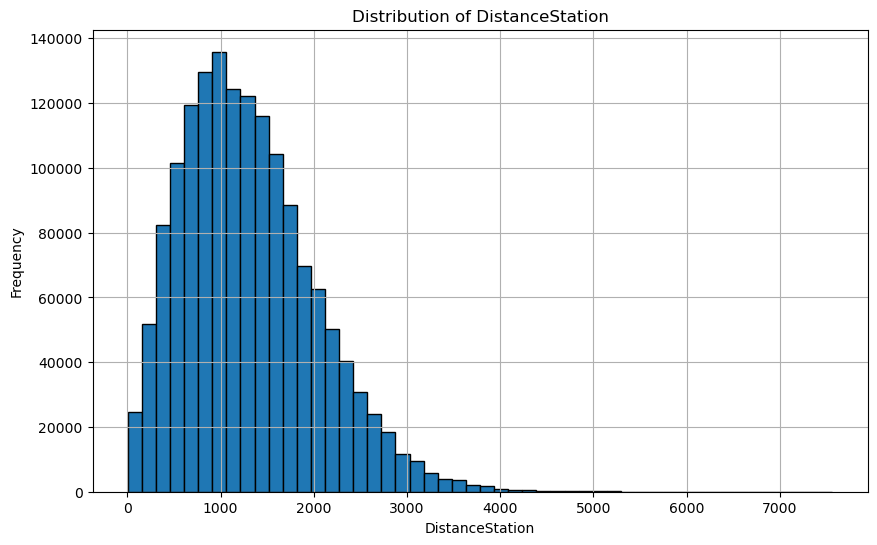

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(df['DistanceStation'], bins=50, edgecolor='black')
plt.title('Distribution of DistanceStation')
plt.xlabel('DistanceStation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537704 entries, 235138081 to 067903-30042024
Data columns (total 36 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   DateTimeCall                           1537704 non-null  datetime64[ns]
 1   DeployedFromStation_Name               1537697 non-null  object        
 2   DeployedFromLocation                   1537157 non-null  float64       
 3   PlusCode_Description                   1537704 non-null  object        
 4   IncidentGroup                          1537704 non-null  object        
 5   StopCodeDescription                    1537704 non-null  object        
 6   PropertyCategory                       1537704 non-null  object        
 7   Postcode_district                      1537704 non-null  object        
 8   IncGeo_BoroughName                     1537704 non-null  object        
 9   IncGeo_WardNameNew      

### 6. Further Analysis

In [58]:
df.to_csv('df_clean_before_NaNs_with_datetime_infos_with_geo.csv', index=True)


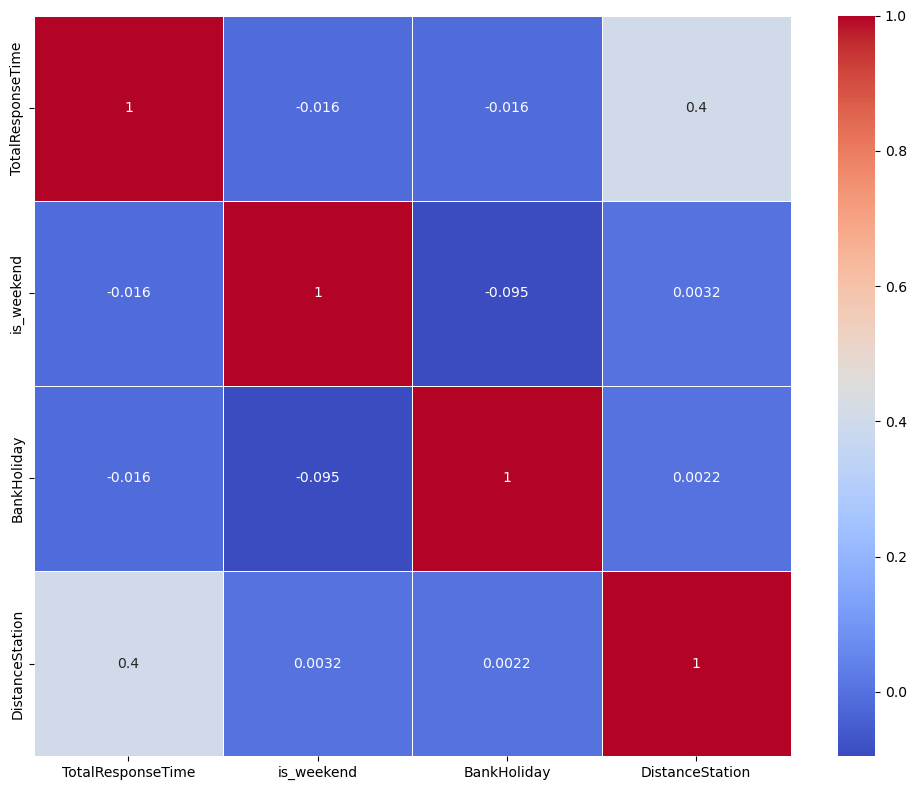

In [102]:
import seaborn as sns

numeric_df = df[['TotalResponseTime', 'is_weekend', 'BankHoliday', 'DistanceStation']]
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=True)
plt.tight_layout()
plt.savefig('/Users/clemenspaulsen/Desktop/Bootcamp/Project/Graphs/Corr_Heat.png', dpi=300,  bbox_inches='tight')
plt.show()


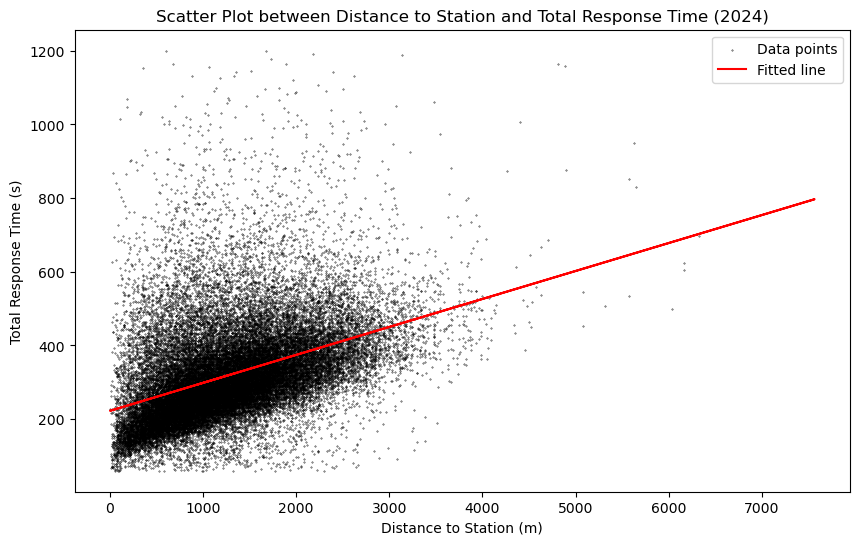

In [104]:
df_2024 = df[df['Year'] == 2024]

# Scatter plot with fitted line
plt.figure(figsize=(10, 6))
plt.scatter(df_2024['DistanceStation'], df_2024['TotalResponseTime'], color='black', s=0.1, label='Data points')  # Smaller dots
plt.xlabel('Distance to Station (m)')
plt.ylabel('Total Response Time (s)')
plt.title('Scatter Plot between Distance to Station and Total Response Time (2024)')

# Fit a line
m, b = np.polyfit(df['DistanceStation'], df['TotalResponseTime'], 1)
plt.plot(df['DistanceStation'], m*df['DistanceStation'] + b, color='red', label='Fitted line')

plt.legend()
plt.savefig('/Users/clemenspaulsen/Desktop/Bootcamp/Project/Graphs/Scatter_Distance.png', dpi=300)
plt.show()

In [54]:
unique_values_count = df['CellEastingNorthing2500'].nunique()
print(unique_values_count)

306


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537704 entries, 235138081 to 067903-30042024
Data columns (total 36 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   DateTimeCall                           1537704 non-null  datetime64[ns]
 1   DeployedFromStation_Name               1537697 non-null  object        
 2   DeployedFromLocation                   1537157 non-null  float64       
 3   PlusCode_Description                   1537704 non-null  object        
 4   IncidentGroup                          1537704 non-null  object        
 5   StopCodeDescription                    1537704 non-null  object        
 6   PropertyCategory                       1537704 non-null  object        
 7   Postcode_district                      1537704 non-null  object        
 8   IncGeo_BoroughName                     1537704 non-null  object        
 9   IncGeo_WardNameNew      

In [78]:
unique_values = df['StopCodeDescription'].unique()
print(unique_values)

['Special Service' 'Secondary Fire' 'AFA' 'False alarm - Good intent'
 'Primary Fire' 'False alarm - Malicious' 'Chimney Fire' 'Late Call'
 'Use of Special Operations Room']


In [80]:
columns_to_keep = ['IncidentGroup', 'StopCodeDescription', 'PropertyCategory', 'TotalResponseTime', 'Month',
                  'Year', 'WeekDay', 'Day_of_Month', 'is_weekend', 'Hour', 'BankHoliday', 'CellEastingNorthing100',
                   'CellEastingNorthing250', 'CellEastingNorthing500', 'CellEastingNorthing1000', 'CellEastingNorthing2500',
                  'CellEastingNorthing5000', 'CellEastingNorthing10000', 'DistanceStation'] 

df_final = df[columns_to_keep]

In [84]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537704 entries, 235138081 to 067903-30042024
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   IncidentGroup             1537704 non-null  object 
 1   StopCodeDescription       1537704 non-null  object 
 2   PropertyCategory          1537704 non-null  object 
 3   TotalResponseTime         1537704 non-null  float64
 4   Month                     1537704 non-null  int64  
 5   Year                      1537704 non-null  int64  
 6   WeekDay                   1537704 non-null  int64  
 7   Day_of_Month              1537704 non-null  int64  
 8   is_weekend                1537704 non-null  int64  
 9   Hour                      1537704 non-null  int64  
 10  BankHoliday               1537704 non-null  int64  
 11  CellEastingNorthing100    1537704 non-null  object 
 12  CellEastingNorthing250    1537704 non-null  object 
 13  CellEastingNorth

In [88]:
unique_values = df_final['is_weekend'].unique()
print(unique_values)

[0 1]
